In [1]:
import pandas as pd
import numpy as np
import time
import datetime
import matplotlib.pyplot as plt
import hdbscan
from sklearn.preprocessing import StandardScaler, RobustScaler
import matplotlib
matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] =False # 한글 폰트를 위함

## 상장기업 데이터프레임 만들기 (코드, 이름)

In [2]:
def read_krx_code():
        """KRX로부터 상장기업 목록 파일을 읽어와서 데이터프레임으로 반환"""
        url = 'http://kind.krx.co.kr/corpgeneral/corpList.do?method='\
            'download&searchType=13'
        krx = pd.read_html(url, header=0)[0]
        krx = krx[['종목코드', '회사명']]
        krx = krx.rename(columns={'종목코드': 'code', '회사명': 'company'})
        krx.code = krx.code.map('{:06d}'.format)
        return krx

In [3]:
code_df = read_krx_code()
code_df

,code,company
0,000210,DL
1,004840,DRB동일
2,155660,DSR
3,078930,GS
4,294870,HDC현대산업개발
...,...,...
2508,169670,코스텍시스템
2509,318660,타임기술
2510,222670,플럼라인생명과학
2511,331660,한국미라클피플사


## 네이버 금융에서 시세 읽어오는 함수 만들기

In [4]:
from bs4 import BeautifulSoup
import requests

def read_naver(code, company):
        """네이버에서 주식 시세를 읽어서 데이터프레임으로 반환"""
        try:
            url = f"http://finance.naver.com/item/sise_day.nhn?code={code}"
            html = BeautifulSoup(requests.get(url,
                headers={'User-agent': 'Mozilla/5.0'}).text, "lxml")
            pgrr = html.find("td", class_="pgRR")
            if pgrr is None:
                return None
            s = str(pgrr.a["href"]).split('=')
            lastpage = s[-1] 
            df = pd.DataFrame()
            for page in range(1, int(lastpage) + 1):
                pg_url = '{}&page={}'.format(url, page)
                df = pd.concat([df, pd.read_html(requests.get(pg_url,
                    headers={'User-agent': 'Mozilla/5.0'}).text)[0]])                                          
            df = df.rename(columns={'날짜':'date','종가':'close','시가':'open','고가':'high',
                                    '저가':'low','거래량':'volume'})
            df['date'] = df['date'].replace('.', '-')
            df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d', errors = 'raise')
            df = df.dropna()
            df[['close', 'open', 'high', 'low', 'volume']] = df[['close', 'open', 'high', 'low', 'volume']].astype(int)
            df = df[['date', 'open', 'high', 'low', 'close', 'volume']]
            df.set_index('date', inplace = True)
        except Exception as e:
            print('Exception occured :', str(e))
            return None
        return df

## 사용자 입력 받기

In [5]:
company_name = input("조회할 종목을 입력하세요: ") # 문제 : 정확한 종목명을 입력받지 못했을 때 인식할 방법

조회할 종목을 입력하세요: SK하이닉스


**입력받은 종목의 코드를 반환하는 작업**

In [6]:
code = code_df.loc[code_df["company"] == company_name].code.values[0]
code

'000660'

**사용자가 입력한 종목에 대한 시세 데이터를 받아와 데이터프레임으로 변환**

In [7]:
df = read_naver(code, company_name)
df

,open,high,low,close,volume
date,,,,,
2022-07-27,101000,101500,98600,100000,3141718
2022-07-26,100500,101000,99100,100500,1636970
2022-07-25,99100,101500,98900,100000,2185108
2022-07-22,102500,102500,100000,100000,3126556
2022-07-21,102000,103000,100500,102500,2143984
...,...,...,...,...,...
1997-01-06,20000,20000,20000,20000,436190
1997-01-04,20000,20000,20000,20000,277690
1997-01-03,20000,20100,20000,20000,145680


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6400 entries, 2022-07-27 to 1996-12-26
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   open    6400 non-null   int64
 1   high    6400 non-null   int64
 2   low     6400 non-null   int64
 3   close   6400 non-null   int64
 4   volume  6400 non-null   int64
dtypes: int64(5)
memory usage: 300.0 KB


## 데이터 프레임에서 추세선에 필요한 부분만 처리해주기

In [9]:
import cufflinks as cf
from dateutil.relativedelta import relativedelta # 최근 n개월 필터링위함

In [10]:
df.index[0].date() # 가장 최근 날짜

datetime.date(2022, 7, 27)

In [11]:
# 최근 7개월 간의 데이터만 뽑아내기 위해 기준점 설정 - 인덱스와 비교하기 위해 datetime 형식으로 변환
start = pd.to_datetime(df.index[0].date() + relativedelta(months = -7))
df = df.loc[df.index > start]

qf = cf.QuantFig(df)

**반응형 차트로 그냥 한번 그려보기^^**

In [12]:
qf.iplot(title = company_name, name = company_name) # 놀랍게도 iplot은 한글이 지원됨

In [13]:
qf.add_sma(periods = 20) # 20일간의 단순이평선
qf.add_bollinger_bands(periods = 20, boll_std = 2) # SMA20에 표준편차 2로 볼린저밴드 적용
qf.iplot(title = company_name, name = company_name)

## 머신러닝 이용하기

**데이터 정규화하기**

In [14]:
scaler = RobustScaler()
df_scale = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)

**모델 훈련하기**

In [15]:
clusterer = hdbscan.HDBSCAN(min_cluster_size = 15) # 하나의 횡보장이 생기기 위한 최소한의 기간
df["dbscan_cluster"] = clusterer.fit_predict(np.array(df_scale['close']).reshape(-1, 1))
len(df["dbscan_cluster"].unique())

4

**시각화하기** - 저항선과 지지선

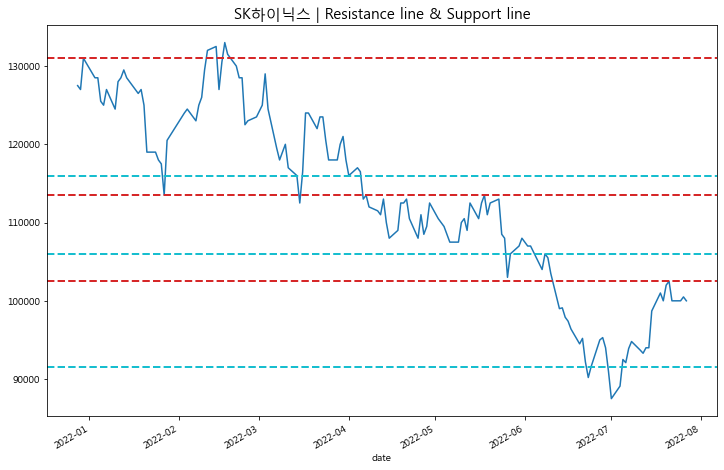

In [16]:
df['close'].plot(figsize = (12, 8))
plt.title(company_name + " | Resistance line & Support line", fontsize = 15)
for n in df["dbscan_cluster"].unique():
    if n != -1:
        plt.axhline(df[df['dbscan_cluster'] == n]['close'].max(), color='C3', linestyle = '--', linewidth = 2) # 저항선
        plt.axhline(df[df['dbscan_cluster'] == n]['close'].min(), color='C9', linestyle = '--', linewidth = 2) # 지지선

**시각화하기** - 추세선

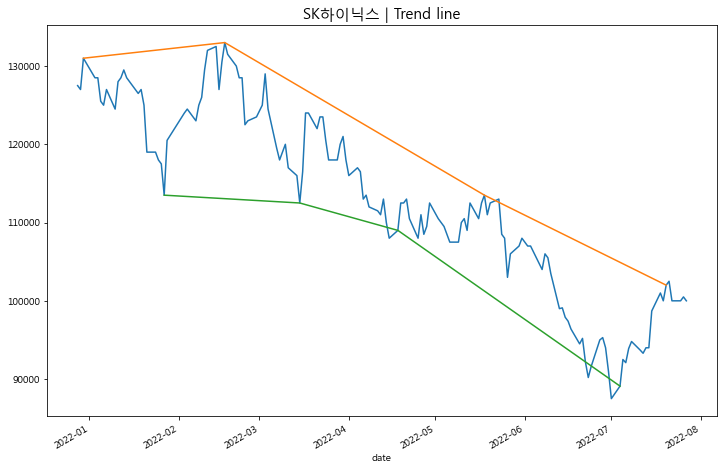

In [17]:
from scipy.signal import argrelextrema
local_max = argrelextrema(df.high.values, np.greater_equal, order = 15) # 전, 후 15일을 기준으로 local max의 인덱스 파악
local_min = argrelextrema(df.low.values, np.less_equal, order = 15) # 전, 후 15일을 기준으로 local min의 인덱스 파악

x_lmax = df.index[local_max]
y_lmax = df.close[x_lmax]
x_lmin = df.index[local_min]
y_lmin = df.close[x_lmin]

df['close'].plot(figsize = (12, 8))
plt.title(company_name + " | Trend line", fontsize = 15)
plt.plot(x_lmax, y_lmax)
plt.plot(x_lmin, y_lmin)